In [1]:
from utils.utils import calculate_attributions

archive_name = 'ucr'
classifier = 'fcn_itr_0'
mode = 'stl' 
root_dir = "G:/My Drive/master thesis/code/xai_tsc" 
itr = '_itr_'
appendix = 'original'
dataset_name = 'GunPoint'
att  = calculate_attributions(root_dir, archive_name, classifier,  \
                                                    dataset_name, appendix, mode,  task=1)

ImportError: cannot import name 'calculate_attributions' from 'utils.utils' (g:\Meine Ablage\master thesis\code\xai-tsc\utils\utils.py)

In [ ]:
import pandas as pd 

pd.read_csv("G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint/experiment_1/fcn/fcn_mt_ae_0/fcn_cam_norm/history.csv")

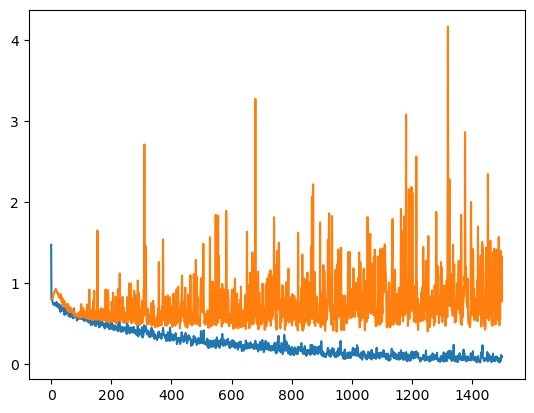

In [69]:
loss = np.loadtxt("G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef/experiment_4/fcn/fcn_mt_ae_iter_0.5_1/fcn_ig_norm/test1499_Loss",delimiter=',')
val_loss = np.loadtxt("G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef/experiment_4/fcn/fcn_mt_ae_iter_0.5_1/fcn_ig_norm/test1499_Val_Loss",delimiter=',')

plt.plot(loss)
plt.plot(val_loss)

In [ ]:
import matplotlib.pyplot as plt 
import tensorflow as tf

tf.zeros(150)
tf.random.uniform((1,150),minval=-1,maxval=1).shape

TensorShape([1, 150])

In [138]:
def norm(values): 
    if not type(values) == np.ndarray:
        return normalize(values.numpy().reshape(1,-1))[0]
    else: 
        return normalize(values.reshape(1,-1))[0]

In [148]:
from utils.constants import CAM_LAYERS
from utils.explanations import get_layer_index
def calculate_cam_attributions(root_dir, archive_name, classifier, dataset_name, data_source, experiment=1, scale='None'):

    #load original data 
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)
    x_train, y_train, x_test, y_test = datasets_dict[dataset_name]

    # transform to binary labels
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train_binary = enc.transform(y_train.reshape(-1, 1)).toarray()
    
    orgx_train = x_train
    orgx_test = x_test
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' /
                    f'/experiment_{experiment}/{classifier.split("_")[:-1][0]}/'/
                    f'{classifier}/{data_source}/best_model.hdf5'  
    #load model 
    #model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' /
    #                                    + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
    #                                    + f'best_model.hdf5'
    
    model = keras.models.load_model(model_path ,compile=False)

    for layer in model.layers: 
        print(layer.name)
    
    #get gap and output layer
    #print(CAM_LAYERS[classifier.split("_")[0]])

    gap = CAM_LAYERS[classifier.split("_")[0]]["last_conv_layer"]
    gap = get_layer_index(model, gap)
    out = CAM_LAYERS[classifier.split("_")[0]]["task_1"]
    out = get_layer_index(model, out)

    w_k_c = model.layers[out].get_weights()[0]  # weights for each filter k for each class c


    # the same input
    new_input_layer = model.inputs
    new_output_layer = [model.layers[gap].output, model.layers[out].output]
    new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)
    
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.layers[gap].output,  model.layers[out].output]
    )
    output = []
    
    y_pos = list(np.unique(y_train))
    # Calculate classwise attribution gap to output
    for orgx_vals,x_vals,y_vals in [[orgx_train,x_train,y_train],[orgx_test,x_test,y_test]]:
        attr = list()

        #conv_out, predicted = new_feed_forward([ts])
        with tf.GradientTape() as tape:
            [conv_out, predicted] = grad_model(x_vals) 
            pred_index = tf.math.argmax(predicted[0])
            tf.print(pred_index)
            class_channel = predicted[:, pred_index]
    
        grads = tape.gradient(tf.convert_to_tensor(class_channel), tf.convert_to_tensor(conv_out))
        #tape.gradient(class_channel, conv_out)
        #tape.gradient(tf.convert_to_tensor(class_channel), tf.convert_to_tensor(conv_out))
        pooled_grads = tf.reduce_mean(grads, axis=(0))

        tf.print(pooled_grads)

        for idx,ts in enumerate(x_vals):
            ts = ts.reshape(1, -1, 1)
            cas = np.zeros(dtype=np.float64, shape=(conv_out.shape[1]))
            [conv_out, predicted] = new_feed_forward([ts])
            for k, w in enumerate(w_k_c[:,np.argmax(predicted)]): #y_pos.index(y_vals[idx])]): #np.argmax(predicted)
                cas += w * conv_out[0, :, k] * pooled_grads[:,k]
            #print(cas, np.mean(cas))
            cas = cas / np.mean(cas)
            if scale == 'minmax': 
                cas = cas - np.min(cas) / (np.max(cas) - np.min(cas))
            elif scale == 'normalized':
                print("normalized") 
                cas = norm(cas)
            
            attr.append([y_vals[idx],orgx_vals[idx],cas])
        output.append(attr)
    return output


In [34]:
dataset = 'Beef'
model_type = 'fcn'
model = 'fcn_mt_conv'
itr = 5
root_dir = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive = 'ucr'
dataset_name = 'Beef'
archive_name = 'ucr'
task  = 1


import tensorflow_addons as tfa
from utils.explanations import integrated_gradients
from keras.utils import CustomObjectScope
import tensorflow.keras as keras
import tensorflow as tf
import os
from utils.explanations import minmax_norm
from utils.explanations import calculate_ig_attributions
#from utils.explanations import calculate_cam_attributions
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.utils import read_dataset
from sklearn.preprocessing import normalize
import numpy as np
import sklearn


ig_link  = f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{model_type}_ig_raw/last_model.hdf5'
#f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/
#cam_model =keras.models.load_model(cam_link ,compile=False)
ig_model = keras.models.load_model(ig_link ,compile=False)


datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)
x_train, y_train, x_test, y_test = datasets_dict[dataset_name]

print(y_test.shape)

for layer in ig_model.layers:
    if 'shared' in layer.name or 'task_1_output' in layer.name: 
        print(layer.name,layer.trainable)

# set gamma 0
print(f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{model_type}_ig_raw/last_model.hdf5')
print(root_dir, archive, f"{model}_{itr}", dataset, f"{model_type}_ig_raw")
ig_attributions = calculate_ig_attributions(root_dir, archive, f"{model}_{itr}", dataset, f"{model_type}_ig_raw", task=1, experiment=1, scale='normalized')

print(ig_model.summary())

pred_1 = ig_model.predict(x_train)

weights = ig_model.get_weights()
# Set layer to non trainable 

for layer in ig_model.layers:
    if 'shared' in layer.name or 'task_1_output' in layer.name: 
        layer.trainable = False


for layer in ig_model.layers:
    print(layer.name,  'shared' in layer.name or 'task_1_output' in layer.name)
    if 'shared' in layer.name or 'task_1_output' in layer.name: 
        print(layer.name,layer.trainable)



ig_model.compile( 
    optimizer = keras.optimizers.Adam(), 
    loss={'task_1_output': 'categorical_crossentropy','task_2_output': 'mse'},
    loss_weights={'task_1_output': 0, 'task_2_output': 1},
    metrics=['accuracy']) 

ig_model.set_weights(weights)




y_train_2 = []
for e in ig_attributions[0]: 
    y_train_2.append(e[2])
y_train_2 = np.array(y_train_2)
y_val_2 = []
for e in ig_attributions[1]: 
    y_val_2.append(e[2])
y_val_2 = np.array(y_val_2)


enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()

print(y_test.shape)
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

print(y_test.shape)

print(y_train.shape,y_train_2.shape)
print(y_test.shape, y_val_2.shape)

hist = ig_model.fit(
{'input_1': x_train},
{'task_1_output': y_train, 'task_2_output': y_train_2},
batch_size=5, 
epochs= 30,
verbose=False, 
validation_data=(
    x_test,
    {'task_1_output': y_test, 'task_2_output': y_val_2})
)


pred_2 = ig_model.predict(x_train)

output = list()
baseline = tf.zeros(len(x_train[0]))

#tf.random.uniform((1,x_train.shape[1]),minval=-1,maxval=1) # tf.zeros(len(x_train[0]))
y_pos = list(np.unique(y_train))
for x_vals,y_vals in [[x_train,y_train],[x_test,y_test]]:
    pred = ig_model.predict(x_vals) if task == 0 else ig_model.predict(x_vals)[0]
    attr = list()
    for idx,ts in enumerate(x_vals):
        series = ts
        ig_att = integrated_gradients(ig_model,baseline,series.astype('float32'),
                                    np.argmax(pred[idx]),
                                    task=task)
                                    #optimize for true values
                                    #y_pos.index(y_vals[idx]),
        attr.append([y_vals[idx],x_vals[idx],ig_att])
    output.append(attr)

#print(ig_model.summary())

ig_attributions[1][0][2]==output[1][0][2]



(30, 1)
shared_l1 True
shared_l2 True
shared_l3 True
shared_l4 True
shared_l5 True
shared_l6 True
shared_l7 True
shared_l8 True
shared_l9 True
task_1_output True
./results/ucr/Beef/experiment_1/fcn/fcn_mt_conv_5/fcn_ig_raw/last_model.hdf5
G:/Meine Ablage/master thesis/code/xai-tsc ucr fcn_mt_conv_5 Beef fcn_ig_raw
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef//experiment_1/fcn/fcn_mt_conv_5/fcn_ig_raw/last_model.hdf5
1/1 [==============================] - 0s 86ms/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 470, 1)]     0           []                               
                                                                                                  
 shared_l1 (Conv1D)             (None, 470, 128)     1152        ['input_1[0][0]']                
 

<tf.Tensor: shape=(470,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, Fal

In [150]:


#-1.5396454e-05 /-0.0003004431

output[1][10][2]


<tf.Tensor: shape=(470,), dtype=float32, numpy=
array([ 7.17588747e-03,  7.10721500e-03,  6.00037212e-03,  5.69318281e-03,
        5.34458878e-03,  6.95934147e-03,  6.67375373e-03,  5.27249090e-03,
        4.71567269e-03,  3.75009328e-03,  3.45098972e-03,  3.55961849e-03,
        3.20049352e-03,  2.23937491e-03,  1.05771748e-03,  4.24463884e-04,
        5.93727418e-05, -1.14738405e-05,  1.86083926e-04,  3.50226008e-04,
        2.85395916e-04,  2.69396085e-04,  2.83700356e-04,  2.90560158e-04,
       -3.53838928e-04, -2.30602385e-03, -5.06945373e-03, -7.02340435e-03,
       -7.82572106e-03, -7.47937709e-03, -5.81449084e-03, -3.33921541e-03,
       -2.22131144e-03, -2.90262949e-04,  1.19263609e-03,  1.86852680e-03,
        3.11380532e-03,  4.98714997e-03,  5.13615087e-03,  4.05823765e-03,
        9.51059395e-04, -2.64821295e-03, -5.05406922e-03, -5.60244173e-03,
       -3.81249725e-03,  1.51000195e-03,  6.53142575e-03,  1.03759570e-02,
        9.40582156e-03,  6.51738793e-03,  3.83594027

[-2.70230928e-03 -1.81174220e-03 -7.22594326e-04 -1.70198339e-03
 -3.99425533e-03 -3.96538572e-03 -4.44568414e-03 -4.07289714e-03
 -3.62860435e-03 -3.43394233e-03 -3.18404450e-03 -2.50272709e-03
 -1.45162898e-03 -3.36166006e-04  5.26399410e-04  1.53545034e-03
  2.70451698e-03  3.76301352e-03  4.58959304e-03  5.64974686e-03
  6.77974336e-03  8.06012750e-03  9.60055832e-03  1.05272448e-02
  1.13131786e-02  1.23456940e-02  1.27323987e-02  1.27760191e-02
  1.34458588e-02  1.47821726e-02  1.58787835e-02  1.71090905e-02
  1.88989844e-02  1.94144640e-02  1.96520332e-02  2.03621015e-02
  2.02338956e-02  2.05317400e-02  2.04327721e-02  2.04311889e-02
  2.08078418e-02  2.31740065e-02  2.79998649e-02  3.39806005e-02
  3.95092666e-02  4.44544517e-02  5.08898646e-02  5.89555129e-02
  6.15374632e-02  4.92295772e-02  2.85754129e-02  6.04603952e-03
 -1.01500275e-02 -2.72877142e-02 -2.28793062e-02 -1.57388877e-02
  2.10788683e-03  2.12598611e-02  4.62433472e-02  6.37981370e-02
  7.42875710e-02  6.45185

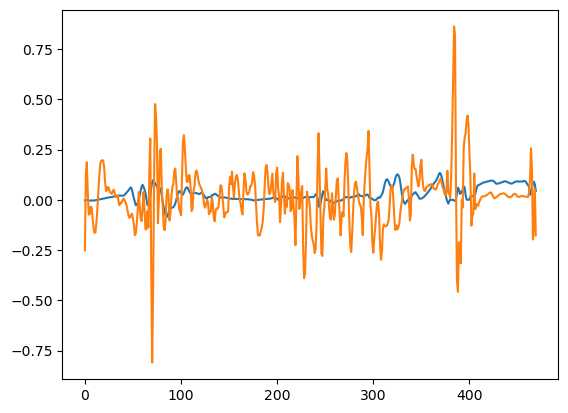

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def norm(values): 
    if not type(values) == np.ndarray:
        return normalize(values.numpy().reshape(1,-1))[0]
    else: 
        return normalize(values.reshape(1,-1))[0]





ts = 2
#pred_1[1][0].flatten()
print(y_train_2[ts])
plt.plot(y_train_2[ts])
plt.plot(pred_2[1][ts].flatten())

print(max(y_train_2[ts]))

In [204]:


y_train_2.shape

(30, 470)

In [47]:
print( f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{model_type}_ig_raw/last_model.hdf5')
ig_link  = f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{model_type}_ig_raw/last_model.hdf5'
ig_model = keras.models.load_model(ig_link ,compile=False)

#yvals = 2
ylen = 470

# Existing model
existing_model = ig_model  # Your existing model

# Select the index of the layer until which you want to freeze
freeze_until_layer_index = 9

# Create a new model with frozen layers
frozen_model = tf.keras.Model(inputs=existing_model.input, outputs=existing_model.layers[freeze_until_layer_index].output)

# Freeze the layers of the frozen_model
for layer in frozen_model.layers:
    layer.trainable = False

# Create new output functions
output_function_1 = tf.keras.layers.GlobalAveragePooling1D()(frozen_model.output)
output_function_1 = tf.keras.layers.Dense(5, activation='softmax', trainable=False, name='task_1_output')(output_function_1)


flatten = keras.layers.Flatten()(frozen_model.output)
conv1d = keras.layers.Conv1DTranspose(filters=1, kernel_size=3,padding='same',activation="linear")(frozen_model.output)
conv1d_flatten =  keras.layers.Flatten()(conv1d)
#output_function_2 = tf.keras.layers.Dense(470, activation='linear', name='task_2_output')(flatten)

#output_function_2  keras.layers.Conv1DTranspose(filters=1, kernel_size=3,padding='same',activation="linear",name='task_2_output')(frozen_model.output)
#output_function_2  = tf.keras.layers.Dense(470, activation='linear', name='task_2_output')(frozen_model.output)

#output_function_2 = keras.layers.Conv1DTranspose(filters=1, kernel_size=3,padding='same',activation="tanh",name='task_2_output')(frozen_model.output)

#output_function_2 = keras.layers.Conv1D(filters=1, kernel_size=8,padding='same',activation="tanh",name='task_2_output')(frozen_model.output)

#Shallow Neural Network
#output_function_2 = tf.keras.layers.Dense(1024, activation='ReLU', )(flatten)
#output_function_2 = tf.keras.layers.Dense(470, activation='linear', name='task_2_output')(output_function_2)

def linear_output(): 
    output_function_2 = tf.keras.layers.Dense(ylen, activation='linear', name='task_2_output')(flatten)
    return output_function_2

def tanh_output(): 
    output_function_2 = tf.keras.layers.Dense(ylen, activation='tanh', name='task_2_output')(flatten)
    return output_function_2

def conv1d_output(): 
    output_function_2 =  keras.layers.Conv1DTranspose(filters=1, kernel_size=3,padding='same',activation="linear", name='task_2_output')(frozen_model.output)
    return output_function_2

#Deep Neural Network
def build_deep_nn():
    interm_function_1 = tf.keras.layers.Dense(2*ylen, activation='relu')(conv1d_flatten)
    interm_function_2 = tf.keras.layers.Dense(2*ylen, activation='relu')(interm_function_1)
    interm_function_3 = tf.keras.layers.Dense(2*ylen, activation='relu')(interm_function_2)
    output_function_2 = tf.keras.layers.Dense(ylen, activation='linear', name='task_2_output')(interm_function_3)
    return output_function_2


def build_encoder(): 
    conv4 = keras.layers.Conv1DTranspose(filters=128, kernel_size=3, padding='same')(frozen_model.output)
    conv4 = keras.layers.Activation('relu')(conv4)
    conv5 = keras.layers.Conv1DTranspose(filters=256, kernel_size=5, padding='same')(conv4)
    conv5 = keras.layers.Activation('relu')(conv5)
    conv6 = keras.layers.Conv1DTranspose(filters=128, kernel_size=8, padding='same')(conv5)
    conv6 = keras.layers.Activation('relu')(conv6)
    output_function_2 = keras.layers.Conv1DTranspose(filters=1, kernel_size=3,padding='same',activation="linear",name='task_2_output')(conv6)
    return output_function_2    


output_function_2 = build_encoder()


# Create the final model with frozen layers and new output functions
final_model = tf.keras.Model(inputs=frozen_model.input, outputs=[output_function_1, output_function_2])

final_model.compile( 
    optimizer = keras.optimizers.Adam(), 
    loss={'task_1_output': 'categorical_crossentropy','task_2_output': 'mse'},
    loss_weights={'task_1_output': 0, 'task_2_output': 1},
    metrics=['accuracy']) 


hist = final_model.fit(
{'input_1': x_train},
{'task_1_output': y_train, 'task_2_output': y_train_2},
batch_size=3, 
epochs= 50,
verbose=False, 
validation_data=(
    x_test,
    {'task_1_output': y_test, 'task_2_output': y_val_2}))

./results/ucr/Beef/experiment_1/fcn/fcn_mt_conv_5/fcn_ig_raw/last_model.hdf5


In [16]:
#ae 0.016
# 0.0035

In [133]:
#final_model.summary()
import matplotlib.pyplot as plt 

1/1 [==============================] - 0s 402ms/step


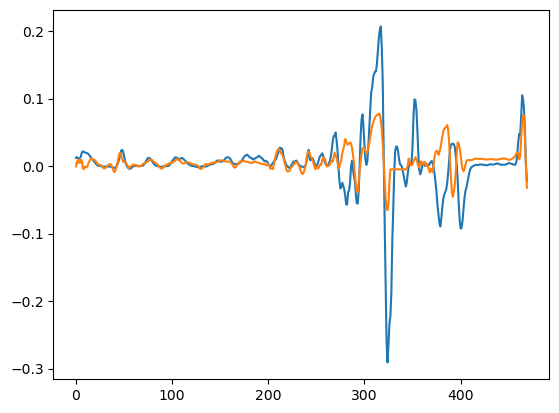

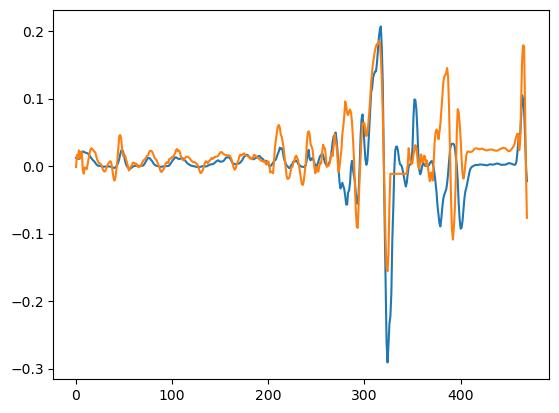

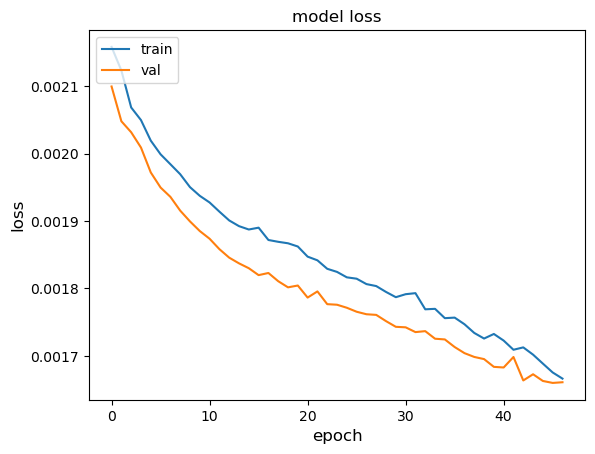

In [48]:
%matplotlib inline
ts = 25

plt.plot(y_val_2[ts])
pr = final_model.predict(x_test)
#print(pr[1][ts])
plt.plot(pr[1][ts])
plt.show()


plt.plot(norm(y_val_2[ts]))
plt.plot(norm(pr[1][ts]))
skip_first_epochs = 3

metric = "loss"
plt.figure()
plt.plot(hist.history[metric][skip_first_epochs:])
plt.plot(hist.history['val_' + metric][skip_first_epochs:])
plt.title('model ' + metric)
plt.ylabel(metric, fontsize='large')
plt.xlabel('epoch', fontsize='large')
plt.legend(['train', 'val'], loc='upper left')

In [75]:
ig_link  = f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{model_type}_ig_raw/last_model.hdf5'
ig_model = keras.models.load_model(ig_link ,compile=False)


# Existing model
existing_model = ig_model.layers[:9]

existing_model

In [367]:
from scipy.stats import wilcoxon

stl = np.array([0.6228571428571429, 0.7833333333333334, 0.8266666666666665,0.830952380952381, 0.785])
mtl = np.array([0.8111111111111111,0.7976190476190477, 0.7761904761904762, 0.7345238095238096, 0.819047619047619])


stl = np.array([0.76])
mtl = np.array([0.78])
#print(stl.mean(), mtl.mean())

statistic, p_value = wilcoxon(stl, mtl)

# Output the results
print("Wilcoxon statistic:", statistic)
print("p-value:", p_value)

Wilcoxon statistic: 0.0
p-value: 1.0


In [56]:
datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'fcn_ig_raw', 470)
x_train, y_train, x_test, y_test = datasets_dict[dataset_name]

y_test.shape

(30, 470)

In [46]:
np.array(y_val_2).shape

(30, 470)

In [35]:
y_train_2 = []
for e in ig_attributions[1]: 
    y_train_2.append(e[2])

In [29]:
#ig_attributions[1][0][2]==output[1][0][2]

<tf.Tensor: shape=(470,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  Tr

In [11]:
import numpy as np
#np.array([1]*10).reshape(2,5)
type(np.argmax([0,1]))


numpy.int64

In [54]:
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Dense(2, input_shape=(2,), activation=None, use_bias=False))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit([[1,1]],[[0]], epochs=1, batch_size=1)

model.predict([[1,1]])

#keras.layers.Dense(units=,activation="None")([1,1])

1/1 [==============================] - 0s 45ms/step


array([[1.6389049, 1.1820223]], dtype=float32)

: 

In [11]:
from utils.utils import read_dataset
archive = 'ucr'
dataset = 'GunPoint'
data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'

(array([[-0.64789, -0.64199, -0.63819, ..., -0.64043, -0.63867, -0.63866],
        [-0.64443, -0.6454 , -0.64706, ..., -0.63493, -0.6345 , -0.6316 ],
        [-0.77835, -0.77828, -0.77715, ..., -0.7042 , -0.70761, -0.70712],
        ...,
        [-0.77913, -0.77838, -0.77574, ..., -0.50501, -0.50373, -0.50438],
        [-0.70303, -0.70262, -0.7025 , ..., -0.64113, -0.64141, -0.64211],
        [-1.4357 , -1.4323 , -1.4329 , ..., -1.4355 , -1.4353 , -1.4309 ]]),
 array([[ -3.4214803 , -17.47745343, -16.67333764, ..., -10.89626039,
         -22.94132841, -13.89705126],
        [ -3.44239172, -17.40849533, -16.82479335, ..., -11.00571488,
         -22.95078287, -13.86467461],
        [  5.27048658,  19.32232294,  16.87921061, ...,  10.83877987,
          25.54376628,  15.11087184],
        ...,
        [ -4.23883249, -16.97099267, -15.2058127 , ..., -13.45840649,
         -22.17918963, -12.38505895],
        [  4.57293284,  19.24112441,  17.42933593, ...,  12.09802533,
          25.1569788

In [8]:
import tensorflow as tf
m_steps=50
c = 0 
for alpha in tf.range(0, len(tf.linspace(start=0.0, stop=1.0, num=m_steps+1)), 32):
    c+=1
print(c)

2


In [4]:
import numpy as np
a = np.array([[0,1,1,1,1],])
b = np.array([[0,0,0,0,1]])
np.corrcoef(a,b)

nan = 1

[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1.125000000000000000e+00,-1.131299999999999972e+00,-1.138300000000000090e+00,-1.146700000000000053e+00,-1.138600000000000056e+00,-1.141399999999999970e+00,-1.143699999999999939e+00,-1.144400000000000084e+00,-1.154900000000000038e+00,-1.146400000000000086e+00,-1.149699999999999944e+00,-1.145699999999999941e+00,-1.141899999999999915e+00,-1.138400000000000079e+00,-1.138500000000000068e+00,-1.133000000000000007e+00,-1.120700000000000029e+00,-1.118600000000000039e+00,-1.100600000000000023e+00,-1.061900000000000066e+00,-9.887700000000000378e-01,-8.980500000000000149e-01,-7.958699999999999664e-01,-7.343199999999999728e-01,-6.968699999999999894e-01,-6.699199999999999600e-01,-6.691099999999999826e-01,-6.819399999999999906e-01,-6.848100000000000298e-01,-6.930500000000000549e-01,-6.808199999999999807e-01,-6.638600000000000056e-01,-6.340200000000000280e-01,-5.958200000000000163e-01,-5.801899999999999835e-01,-5.266199999999999770e-01,-4.322400000000000131e-01,-2.702700000000000102e-01,-1.031900000000000039e-01,7.854200000000000070e-02,2.843600000000000017e-01,4.541000000000000036e-01,5.741000000000000547e-01,7.071499999999999453e-01,8.182300000000000129e-01,9.250800000000000134e-01,9.756200000000000427e-01,1.022599999999999953e+00,1.096999999999999975e+00,1.110300000000000065e+00,1.147999999999999909e+00,1.157599999999999962e+00,1.149799999999999933e+00,1.159499999999999975e+00,1.151699999999999946e+00,1.157499999999999973e+00,1.149499999999999966e+00,1.153299999999999992e+00,1.147299999999999986e+00,1.153000000000000025e+00,1.167100000000000026e+00,1.154300000000000104e+00,1.157599999999999962e+00,1.171999999999999931e+00,1.167899999999999938e+00,1.178399999999999892e+00,1.183799999999999963e+00,1.182900000000000063e+00,1.171699999999999964e+00,1.192499999999999893e+00,1.192199999999999926e+00,1.184900000000000064e+00,1.187000000000000055e+00,1.174600000000000088e+00,1.183200000000000029e+00,1.173599999999999977e+00,1.173599999999999977e+00,1.186800000000000077e+00,1.182099999999999929e+00,1.195400000000000018e+00,1.174900000000000055e+00,1.186900000000000066e+00,1.190299999999999914e+00,1.197300000000000031e+00,1.192299999999999915e+00,1.186099999999999932e+00,1.187999999999999945e+00,1.197999999999999954e+00,1.196299999999999919e+00,1.202299999999999924e+00,1.204499999999999904e+00,1.210599999999999898e+00,1.215700000000000003e+00,1.197699999999999987e+00,1.205699999999999994e+00,1.201799999999999979e+00,1.195500000000000007e+00,1.165799999999999947e+00,1.137299999999999978e+00,1.073199999999999932e+00,1.009100000000000108e+00,9.082299999999999818e-01,7.678399999999999670e-01,6.441000000000000059e-01,4.729400000000000270e-01,3.394599999999999840e-01,2.128200000000000092e-01,4.918499999999999955e-02,-8.244600000000000539e-02,-2.310300000000000131e-01,-3.668899999999999939e-01,-4.641199999999999770e-01,-5.303900000000000281e-01,-5.896099999999999675e-01,-6.478599999999999914e-01,-6.899100000000000232e-01,-7.202600000000000113e-01,-7.389999999999999902e-01,-7.511900000000000244e-01,-7.625899999999999901e-01,-7.656600000000000072e-01,-7.854900000000000215e-01,-7.836899999999999977e-01,-7.889199999999999546e-01,-7.912599999999999634e-01,-8.018899999999999917e-01,-8.054999999999999938e-01,-8.148900000000000032e-01,-8.158900000000000041e-01,-8.186900000000000288e-01,-8.351300000000000390e-01,-8.446399999999999464e-01,-8.543199999999999683e-01,-8.730200000000000182e-01,-8.855100000000000193e-01,-9.200300000000000145e-01,-9.482000000000000428e-01,-9.966399999999999704e-01,-1.053900000000000059e+00,-1.137000000000000011e+00,-1.205600000000000005e+00,-1.281199999999999894e+00,-1.323399999999999910e+00,-1.345800000000000107e+00,-1.344500000000000028e+00,-1.301099999999999923e+00,-1.265900000000000025e+00,-1.212699999999999889e+00,-1.206199999999999939e+00,-1.218399999999999928e+00].count(1)

150

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow.keras as keras
import os 
root_dir = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive_name = 'ucr'
classifier = 'fcn_mt_ae_1.0'
#classifier = 'fcn_mt_dense_itr_'
dataset_name =  'GunPoint'
data_source = 'original'
mode = 'mtl'

model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' /
                                    + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                    + f'best_model.hdf5'
#print(model_path)

model = keras.models.load_model(model_path ,compile=False)


In [35]:
#model.summary()
softm = -2
print(model.layers[softm].name)
#print(model.layers["activation_2"])

def get_layer_index(layer_name):
    layer_names = [layer.name for layer in model.layers]
    print(layer_names)
    layer_idx = layer_names.index(layer_name)
    return layer_idx

model.layers

get_layer_index("activation_2")#"task_1_output")

task_1_output
['input_1', 'conv1d', 'batch_normalization', 'activation', 'conv1d_1', 'batch_normalization_1', 'activation_1', 'conv1d_2', 'batch_normalization_2', 'activation_2', 'average_pooling1d', 'up_sampling1d', 'conv1d_transpose', 'batch_normalization_3', 'activation_3', 'conv1d_transpose_1', 'batch_normalization_4', 'activation_4', 'conv1d_transpose_2', 'batch_normalization_5', 'global_average_pooling1d', 'activation_5', 'task_1_output', 'task_2_output']


9

In [3]:
from utils.explanations import calculate_cam_attributions
root_dir = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive_name = 'ucr'
classifier = 'fcn_mt_ae_1.0'
#classifier = 'fcn_mt_dense_itr_'
dataset_name =  'GunPoint'
data_source = 'original'
mode = 'mtl'

calculate_cam_attributions(root_dir, archive_name, classifier, dataset_name, data_source)


[[[array([2.]),
   array([-0.64789 , -0.64199 , -0.63819 , -0.63826 , -0.63835 , -0.6387  ,
          -0.64305 , -0.64377 , -0.64505 , -0.64712 , -0.64915 , -0.65125 ,
          -0.65729 , -0.6622  , -0.66123 , -0.66099 , -0.66156 , -0.66226 ,
          -0.66191 , -0.66274 , -0.66093 , -0.66345 , -0.66219 , -0.66234 ,
          -0.66171 , -0.66139 , -0.66141 , -0.66145 , -0.66037 , -0.65911 ,
          -0.65974 , -0.65818 , -0.6584  , -0.65735 , -0.65852 , -0.65849 ,
          -0.65737 , -0.65436 , -0.65252 , -0.65132 , -0.64814 , -0.64733 ,
          -0.6471  , -0.64486 , -0.6436  , -0.64349 , -0.64265 , -0.6421  ,
          -0.64448 , -0.64889 , -0.65766 , -0.6612  , -0.64966 , -0.61017 ,
          -0.53743 , -0.46503 , -0.35853 , -0.28314 , -0.17745 ,  0.15825 ,
           0.35028 ,  0.48241 ,  0.60381 ,  0.7971  ,  0.98755 ,  1.2038  ,
           1.4065  ,  1.5962  ,  1.7128  ,  1.7788  ,  1.7938  ,  1.7971  ,
           1.8102  ,  1.8206  ,  1.8172  ,  1.8316  ,  1.8316  ,  1.829 

In [1]:
from utils.constants import CAM_LAYERS

def get_layer_index(model, layer_name):
    layer_names = [layer.name for layer in model.layers]
    print(layer_names)
    layer_idx = layer_names.index(layer_name)
    return layer_idx


def calculate_cam_attribution(root_dir, archive_name, classifier, dataset_name, data_source, task=1):

    #load data
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)
    x_train, y_train, x_test, y_test = datasets_dict[dataset_name]

    # transform to binary labels
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train_binary = enc.transform(y_train.reshape(-1, 1)).toarray()
    
    orgx_train = x_train
    orgx_test = x_test
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

    #load model 
    model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                        + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                        + f'best_model.hdf5'
    
    model = keras.models.load_model(model_path ,compile=False)
    
    #get gap and output layer
    gap = CAM_LAYERS[classifier.split("_")[0]]["gap_layer"]
    gap = get_layer_index(model, gap)
    out = CAM_LAYERS[classifier.split("_")[0]]["task_1"]
    out = get_layer_index(model, out)

            
    w_k_c = model.layers[out].get_weights()[0]  # weights for each filter k for each class c

    # the same input
    new_input_layer = model.inputs
    new_output_layer = [model.layers[gap].output, model.layers[out].output]
    new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)
    output = []

    # Calculate classwise attribution gap to output
    for orgx_vals,x_vals,y_vals in [[orgx_train,x_train,y_train],[orgx_test,x_test,y_test]]:
        attr = list()
        for idx,ts in enumerate(x_vals):
            ts = ts.reshape(1, -1, 1)
            [conv_out, predicted] = new_feed_forward([ts])
            cas = np.zeros(dtype=np.float64, shape=(conv_out.shape[1]))

            for k, w in enumerate(w_k_c[:,int(y_vals[idx]-1)]):
                cas += w * conv_out[0, :, k] 
            attr.append([y_vals[idx],orgx_vals[idx],cas])
        output.append(attr)
    return output

In [118]:
output_directory = 'G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_itr_0/original/'
def save_attributions(output_directory, att, task, save_mode = 1): 
    task_name = 'task_1' if task == 1 else 'task_2'
    att_train, att_test = att
    if save_mode == 1: 
        np.save(output_directory  + f'calculated_attribution_train_{task_name}.npy', att_train)
        np.save(output_directory  + f'calculated_attribution_test_{task_name}.npy', att_test)
    if save_mode == 2:
        pd.DataFrame(att_train, columns=['ts_nr','x_val','y_val','attributions','pred_y','true_y','orginal_ts'])\
        .to_csv(output_directory + f'calculated_attribution_train_{task_name}.csv')
        pd.DataFrame(att_train, columns=['ts_nr','x_val','y_val','attributions','pred_y','true_y','orginal_ts'])\
        .to_csv(output_directory + f'calculated_attribution_test_{task_name}.csv')
    print("Saved attributions")

save_attributions(output_directory, att, task=1)

Saved attributions


In [111]:
type(np.load(output_directory + f'calculated_attribution_train_task_1.npy', allow_pickle = True)[0][3])

numpy.ndarray

In [26]:
df = pd.read_csv(output_directory + "calculated_attribution_train.csv")
df.iloc[0]

Unnamed: 0                                                      0
ts_nr                                                           0
x_val           [0.00000000e+00 7.45372686e-02 1.49074537e-01 ...
y_val           [-0.64789    -0.64745023 -0.64701046 ... -0.63...
attributions                              [20 19 17 ... 10 10 10]
pred_y                                                          0
true_y                                                          1
orginal_ts      [-0.64789  -0.64199  -0.63819  -0.63826  -0.63...
Name: 0, dtype: object

In [44]:
output_directory = 'G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_mt_itr_0/unbalanced_exp/'

In [40]:
archive_name = 'ucr'
classifier = 'fcn_mt_itr_0'
mode = 'mtl' 
root_dir = "G:/My Drive/master thesis/code/dl-4-tsc-mtl" 
itr = '_itr_'
appendix = 'unbalanced_exp'
dataset_name = 'GunPoint'
att_1  = calculate_attributions(root_dir, archive_name, classifier,  \
                                                    dataset_name, appendix, mode,  task=1)

G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_mt_itr_0/unbalanced_exp/best_model.hdf5
yes
(50, 150, 1) (150, 150, 1)


In [46]:
att_2  = calculate_attributions(root_dir, archive_name, classifier,  \
                                                    dataset_name, appendix, mode,  task=2)

G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_mt_itr_0/unbalanced_exp/best_model.hdf5
(50, 150, 1) (150, 150, 1)


In [47]:
save_attributions(output_directory, att_1, task=1)
save_attributions(output_directory, att_2, task=2)

Saved attributions
Saved attributions


In [101]:
import numpy as np
y_true = []
y_pred = []

for i in att_2[1]:
    y_pred.append(i[4])
    y_true.append(i[5])

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(y_true.shape,set(y_true),set(y_pred))


(150,) {0, 1, 2} {1, 2}


   0    1  2
0  0    9  0
1  0  129  4
2  0    7  1


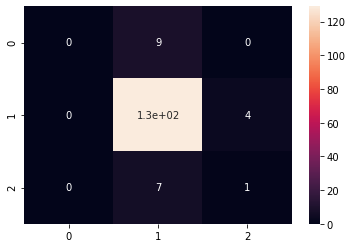

In [102]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
import seaborn as sns

cfm = confusion_matrix(y_true,y_pred)

cfm = pd.DataFrame(cfm)

# y_test  : actual labels or target
# y_preds : predicted labels or target
sns.heatmap(cfm,annot=True);
print(cfm)

In [94]:
creport = classification_report(y_true,y_pred,labels=list(set(y_true)),output_dict=True)

C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
pd.DataFrame(creport)

,0,1,2,accuracy,macro avg,weighted avg
precision,0.0,0.875000,1.000000,0.88,0.625000,0.835000
recall,0.0,1.000000,0.400000,0.88,0.466667,0.880000
f1-score,0.0,0.933333,0.571429,0.88,0.501587,0.841143
support,3.0,42.000000,5.000000,0.88,50.000000,50.000000


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

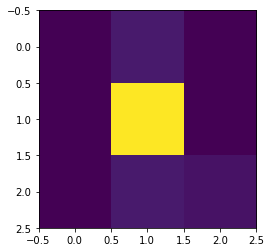

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

display_labels = set(y_true)

disp = ConfusionMatrixDisplay(confusion_matrix=cfm,
                              display_labels=display_labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
#confusion_matrix=np.asarray([[13099,7004],[27420,544967]]), display_labels= np.asarray([0,1])) 
disp = disp.plot(include_values=cfm)
                 #cmap=cmap, ax=ax, xticks_rotation=xticks_rotation)



plt.show()